In [8]:
import warnings, os
warnings.filterwarnings("ignore")

from copy import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score


import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load

from aggmap import AggMap, loadmap
from aggmap import AggMapNet as AggModel

from aggmap.AggMapNet import load_model, save_model
from aggmap import show


np.random.seed(666) #just for reaptable results


def score(dfr):
    y_true = dfr.y_true
    y_score = dfr.y_score
    y_pred = dfr.y_pred

    '''
    the metrics are taken from orignal paper:
    Meta-Signer: Metagenomic Signature Identifier based on Rank Aggregation of Features
    https://github.com/YDaiLab/Meta-Signer/blob/bd6a1cd98d1035f848ecb6e53d9ee67a85871db2/src/utils/metasigner_io.py#L34
    '''
    auc = roc_auc_score(y_true, y_score, average='weighted')        
    mcc = matthews_corrcoef(y_true, y_pred)
    pres = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    
    print('roc-auc: %.3f, mcc: %.3f, pres: %.3f, recall: %.3f, f1: %.3f' % (auc, mcc, pres, recall, f1))

    return acc, auc, mcc, pres, recall, f1

# read data

In [9]:
task = 'Obesity'
data_path = '../../../01_data/species_level/%s/' % (task)
save_dir = '%s_results' % task
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

dfa = pd.read_csv(os.path.join(data_path, 'abundance.tsv'),sep='\t', header=None, index_col=0)
dfy = pd.read_csv(os.path.join(data_path, 'labels.txt'),sep='\t', header=None)
dfx = dfa.T
dfy = pd.get_dummies(dfy[0].map({'obesity':1, 'leaness':0}))
Y = dfy.values

# generate Fmaps

In [10]:
#could be optimized
featHPs = {"best_fill":1e-2, "best_scale_method":'standard', "best_channel_number":8}
dfx = np.log(dfx + featHPs.get('best_fill'))
mp = AggMap(dfx, metric = 'correlation')
mp = mp.fit(cluster_channels = featHPs.get('best_channel_number'), verbose = 0)

mp.plot_grid(save_dir)
mp.plot_scatter(save_dir)
mp.save(os.path.join(save_dir, 'agg.mp'))

X = mp.batch_transform(dfx.values, scale = featHPs.get('best_scale_method')) # NaN values should be the lowest value

2022-10-03 17:37:22,908 - INFO - [bidd-aggmap] - Calculating distance ...
2022-10-03 17:37:22,914 - INFO - [bidd-aggmap] - the number of process is 16


100%|####################################################################################################################################| 465/465 [00:00<00:00, 4837.31it/s]


2022-10-03 17:37:27,729 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2022-10-03 17:37:28,144 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2022-10-03 17:37:28,424 - INFO - [bidd-aggmap] - Finished
2022-10-03 17:37:28,429 - INFO - [bidd-aggmap] - generate file: Obesity_results/feature points_465_correlation_umap_mp
2022-10-03 17:37:28,434 - INFO - [bidd-aggmap] - save html file to Obesity_results/feature points_465_correlation_umap_mp
2022-10-03 17:37:28,435 - INFO - [bidd-aggmap] - generate file: Obesity_results/feature points_465_correlation_umap_scatter
2022-10-03 17:37:28,440 - INFO - [bidd-aggmap] - save html file to Obesity_results/feature points_465_correlation_umap_scatter


100%|####################################################################################################################################| 253/253 [00:00<00:00, 2709.04it/s]


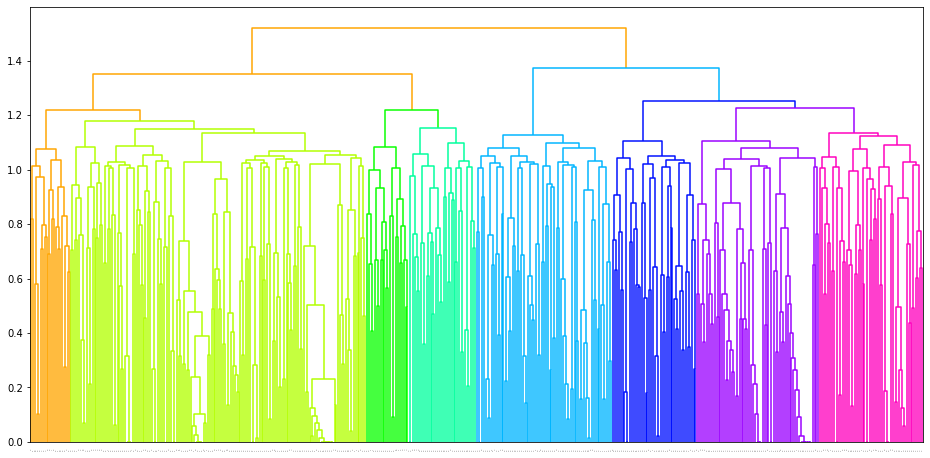

In [11]:
fig_tree = mp.plot_tree(add_leaf_labels = False, leaf_font_size = 1)
fig_tree.savefig(os.path.join(save_dir, 'tree.png'), bbox_inches='tight', dpi=300)

# 10FCV

In [12]:
gpuid = 0

outer_fold = 10
repeat_seeds = [8, 16, 32, 64, 128, 256, 1024, 2048, 4096, 8192] #10 repeats random seeds 8, 16, 32, 64, 128

each_fold_results = []
run_all_res = []

for i, repeat_seed in enumerate(repeat_seeds): 
    outer = StratifiedKFold(n_splits = outer_fold, shuffle = True, random_state = repeat_seed)
    outer_idx = outer.split(range(len(dfy)), dfy.idxmax(axis=1))
    run_one_res = []
    one_repeat_results = []
    for j, idx in enumerate(outer_idx):
        fold_num = "fold_%s" % str(j).zfill(2) 
        print('#'*50 + ' repeat_seed: %s; %s ' % (repeat_seed, fold_num) + '#'*50 )
        
        train_idx, test_idx = idx

        testY = Y[test_idx]
        testX = X[test_idx]
        
        trainX = X[train_idx]
        trainY = Y[train_idx]

        print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

        clf = AggModel.MultiClassEstimator(epochs = 50,  batch_size = 2, verbose = 0, gpuid=gpuid) #
        clf.fit(trainX, trainY)  #, 
        
        ## save model for explaination
        if i == 0:
            clf.save_model(os.path.join(save_dir, '%s.model' % fold_num))
            paras = clf.get_params()
            paras.update({'featHPs':featHPs})
            pd.Series(paras).to_json(os.path.join(save_dir, 'HPs.json'))

        pred_proba = clf.predict_proba(testX)
        y_true = testY[:,1] 
        y_score = pred_proba[:,1]
        y_pred = np.argmax(pred_proba, axis=1)
        
        dfr = pd.DataFrame([y_true, y_score, y_pred]).T
        dfr.columns = ['y_true', 'y_score', 'y_pred']
        dfr.index = dfy.iloc[test_idx].index
        acc, auc, mcc, pres, recall, f1  = score(dfr)
        run_one_res.append(dfr)
        ts = pd.Series([acc, auc, mcc, pres, recall, f1, i, repeat_seed]).round(3)
        ts.index = ['acc','auc', 'mcc', 'pres', 'recall', 'f1', 'i', 'repeat_seed']
        print(ts.to_dict())
        each_fold_results.append(ts.to_dict())    
        one_repeat_results.append(ts.to_dict())
    print('\n\nresults for seed %s' % repeat_seed)
    print(pd.DataFrame(one_repeat_results).mean().to_dict())
    
    run_all_res.append(pd.concat(run_one_res))

################################################## repeat_seed: 8; fold_00 ##################################################

 input train and test X shape is (227, 22, 22, 8), (26, 22, 22, 8) 
MultiClassEstimator(batch_norm=False, batch_size=2, conv1_kernel_size=13,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=50, gpuid='0', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to Obesity_results/fold_00.model
roc-auc: 0.647, mcc: 0.150, pres: 0.615, recall: 0.615, f1: 0.615
{'acc': 0.615, 'auc': 0.647, 'mcc': 0.15, 'pres': 0.615, 'recall': 0.615, 'f1': 0.615, 'i': 0.0, 'repeat_seed': 8.0}
################################################## repeat_seed: 8; fold_01 #########################################

In [13]:
pd.DataFrame(each_fold_results).groupby('repeat_seed').mean().mean()

acc       0.64510
auc       0.64000
mcc       0.18306
pres      0.63065
recall    0.64510
f1        0.62798
i         4.50000
dtype: float64

In [14]:
pd.DataFrame(each_fold_results).groupby('repeat_seed').std().mean()

acc       0.081273
auc       0.114885
mcc       0.205598
pres      0.098576
recall    0.081273
f1        0.088825
i         0.000000
dtype: float64

In [15]:
pd.DataFrame(each_fold_results).to_csv(os.path.join(save_dir, 'performance_results.csv'))

# feature importance

In [16]:
all_imps = []
for i in range(10):
    clf = load_model(os.path.join(save_dir, 'fold_%s.model' % str(i).zfill(2)))
    dfe = clf.explain_model(mp, clf.X_, clf.y_, binary_task=True, apply_logrithm=False)
    df_imp = dfe.col_1_importance.to_frame(name = 'fold_%s_imp' % str(i).zfill(2))
    all_imps.append(df_imp)

8/8 [==============================] - 0s 917us/step
calculating feature importance for column 1 ...


  0%|                                                                                                                                                | 0/484 [00:00<?, ?it/s]

149/149 [==============================] - 1s 3ms/step


  4%|#####8                                                                                                                                 | 21/484 [00:00<00:13, 34.28it/s]

142/142 [==============================] - 1s 4ms/step


  8%|###########4                                                                                                                           | 41/484 [00:01<00:13, 32.00it/s]

142/142 [==============================] - 1s 4ms/step


 13%|#################                                                                                                                      | 61/484 [00:01<00:14, 30.08it/s]

142/142 [==============================] - 0s 3ms/step


 17%|######################5                                                                                                                | 81/484 [00:02<00:12, 31.44it/s]

142/142 [==============================] - 0s 831us/step


 21%|###########################9                                                                                                          | 101/484 [00:02<00:09, 40.89it/s]

142/142 [==============================] - 0s 2ms/step


 25%|#################################5                                                                                                    | 121/484 [00:03<00:08, 42.18it/s]

142/142 [==============================] - 0s 2ms/step


 29%|#######################################                                                                                               | 141/484 [00:03<00:07, 43.34it/s]

142/142 [==============================] - 0s 2ms/step


 33%|############################################5                                                                                         | 161/484 [00:04<00:07, 42.92it/s]

142/142 [==============================] - 0s 3ms/step


 37%|##################################################1                                                                                   | 181/484 [00:04<00:07, 41.62it/s]

142/142 [==============================] - 0s 2ms/step


 42%|#######################################################6                                                                              | 201/484 [00:04<00:06, 46.22it/s]

142/142 [==============================] - 0s 3ms/step


 46%|#############################################################1                                                                        | 221/484 [00:05<00:06, 42.33it/s]

142/142 [==============================] - 0s 2ms/step


 50%|##################################################################7                                                                   | 241/484 [00:05<00:05, 43.53it/s]

142/142 [==============================] - 1s 4ms/step


 54%|########################################################################2                                                             | 261/484 [00:06<00:05, 38.59it/s]

142/142 [==============================] - 0s 3ms/step


 58%|#############################################################################7                                                        | 281/484 [00:07<00:05, 36.95it/s]

142/142 [==============================] - 1s 4ms/step


 62%|###################################################################################3                                                  | 301/484 [00:07<00:05, 34.99it/s]

142/142 [==============================] - 0s 3ms/step


 66%|########################################################################################8                                             | 321/484 [00:08<00:04, 36.20it/s]

142/142 [==============================] - 0s 744us/step


 70%|##############################################################################################4                                       | 341/484 [00:08<00:03, 44.83it/s]

142/142 [==============================] - 0s 2ms/step


 75%|###################################################################################################9                                  | 361/484 [00:09<00:02, 44.68it/s]

142/142 [==============================] - 0s 3ms/step


 79%|#########################################################################################################4                            | 381/484 [00:09<00:02, 41.94it/s]

142/142 [==============================] - 0s 2ms/step


 83%|###############################################################################################################                       | 401/484 [00:10<00:01, 42.78it/s]

142/142 [==============================] - 0s 3ms/step


 87%|####################################################################################################################5                 | 421/484 [00:10<00:01, 41.53it/s]

142/142 [==============================] - 0s 3ms/step


 91%|##########################################################################################################################            | 441/484 [00:11<00:01, 40.06it/s]

142/142 [==============================] - 0s 745us/step


 95%|###############################################################################################################################6      | 461/484 [00:11<00:00, 48.15it/s]

142/142 [==============================] - 0s 3ms/step


 99%|#####################################################################################################################################1| 481/484 [00:11<00:00, 44.83it/s]

22/22 [==============================] - 0s 2ms/step


100%|######################################################################################################################################| 484/484 [00:11<00:00, 40.67it/s]


8/8 [==============================] - 0s 959us/step
calculating feature importance for column 1 ...


  0%|                                                                                                                                                | 0/484 [00:00<?, ?it/s]

149/149 [==============================] - 0s 1ms/step


  4%|#####8                                                                                                                                 | 21/484 [00:00<00:06, 67.55it/s]

142/142 [==============================] - 0s 3ms/step


  8%|###########4                                                                                                                           | 41/484 [00:00<00:09, 47.67it/s]

142/142 [==============================] - 0s 2ms/step


 13%|#################                                                                                                                      | 61/484 [00:01<00:08, 48.91it/s]

142/142 [==============================] - 0s 3ms/step


 17%|######################5                                                                                                                | 81/484 [00:01<00:08, 45.98it/s]

142/142 [==============================] - 0s 3ms/step


 21%|###########################9                                                                                                          | 101/484 [00:02<00:09, 40.54it/s]

142/142 [==============================] - 1s 4ms/step


 25%|#################################5                                                                                                    | 121/484 [00:02<00:10, 35.38it/s]

142/142 [==============================] - 1s 4ms/step


 29%|#######################################                                                                                               | 141/484 [00:03<00:10, 33.76it/s]

142/142 [==============================] - 0s 3ms/step


 33%|############################################5                                                                                         | 161/484 [00:04<00:08, 36.29it/s]

142/142 [==============================] - 0s 777us/step


 37%|##################################################1                                                                                   | 181/484 [00:04<00:06, 45.13it/s]

142/142 [==============================] - 0s 3ms/step


 42%|#######################################################6                                                                              | 201/484 [00:04<00:06, 42.08it/s]

142/142 [==============================] - 0s 1ms/step


 46%|#############################################################1                                                                        | 221/484 [00:05<00:05, 48.39it/s]

142/142 [==============================] - 0s 3ms/step


 50%|##################################################################7                                                                   | 241/484 [00:05<00:05, 45.88it/s]

142/142 [==============================] - 0s 1ms/step


 54%|########################################################################2                                                             | 261/484 [00:05<00:04, 51.59it/s]

142/142 [==============================] - 0s 3ms/step


 58%|#############################################################################7                                                        | 281/484 [00:06<00:04, 44.81it/s]

142/142 [==============================] - 0s 3ms/step


 62%|###################################################################################3                                                  | 301/484 [00:06<00:04, 43.58it/s]

142/142 [==============================] - 0s 2ms/step


 66%|########################################################################################8                                             | 321/484 [00:07<00:03, 46.14it/s]

142/142 [==============================] - 0s 854us/step


 70%|##############################################################################################4                                       | 341/484 [00:07<00:02, 54.09it/s]

142/142 [==============================] - 0s 3ms/step


 75%|###################################################################################################9                                  | 361/484 [00:08<00:02, 46.88it/s]

142/142 [==============================] - 0s 3ms/step


 79%|#########################################################################################################4                            | 381/484 [00:08<00:02, 41.65it/s]

142/142 [==============================] - 0s 2ms/step


 83%|###############################################################################################################                       | 401/484 [00:09<00:01, 45.70it/s]

142/142 [==============================] - 0s 2ms/step


 87%|####################################################################################################################5                 | 421/484 [00:09<00:01, 48.34it/s]

142/142 [==============================] - 0s 3ms/step


 91%|##########################################################################################################################            | 441/484 [00:10<00:00, 43.11it/s]

142/142 [==============================] - 1s 4ms/step


 95%|###############################################################################################################################6      | 461/484 [00:10<00:00, 37.82it/s]

142/142 [==============================] - 1s 4ms/step


 99%|#####################################################################################################################################1| 481/484 [00:11<00:00, 35.56it/s]

22/22 [==============================] - 0s 872us/step


100%|######################################################################################################################################| 484/484 [00:11<00:00, 42.52it/s]

8/8 [==============================] - 0s 953us/step


calculating feature importance for column 1 ...


  0%|                                                                                                                                                | 0/484 [00:00<?, ?it/s]

149/149 [==============================] - 1s 4ms/step


  4%|#####8                                                                                                                                 | 21/484 [00:00<00:15, 30.15it/s]

142/142 [==============================] - 0s 3ms/step


  8%|###########4                                                                                                                           | 41/484 [00:01<00:13, 32.18it/s]

142/142 [==============================] - 0s 3ms/step


 13%|#################                                                                                                                      | 61/484 [00:01<00:12, 33.96it/s]

142/142 [==============================] - 0s 2ms/step


 17%|######################5                                                                                                                | 81/484 [00:02<00:10, 39.23it/s]

142/142 [==============================] - 1s 4ms/step


 21%|###########################9                                                                                                          | 101/484 [00:02<00:10, 36.70it/s]

142/142 [==============================] - 0s 1ms/step


 25%|#################################5                                                                                                    | 121/484 [00:03<00:08, 42.94it/s]

142/142 [==============================] - 0s 2ms/step


 29%|#######################################                                                                                               | 141/484 [00:03<00:07, 43.29it/s]

142/142 [==============================] - 0s 2ms/step


 33%|############################################5                                                                                         | 161/484 [00:04<00:07, 43.85it/s]

142/142 [==============================] - 0s 3ms/step


 37%|##################################################1                                                                                   | 181/484 [00:04<00:07, 40.83it/s]

142/142 [==============================] - 1s 4ms/step


 42%|#######################################################6                                                                              | 201/484 [00:05<00:07, 35.89it/s]

142/142 [==============================] - 0s 3ms/step


 46%|#############################################################1                                                                        | 221/484 [00:05<00:07, 35.77it/s]

142/142 [==============================] - 1s 4ms/step


 50%|##################################################################7                                                                   | 241/484 [00:06<00:07, 33.68it/s]

142/142 [==============================] - 0s 3ms/step


 54%|########################################################################2                                                             | 261/484 [00:07<00:06, 34.42it/s]

142/142 [==============================] - 0s 3ms/step


 58%|#############################################################################7                                                        | 281/484 [00:07<00:05, 35.32it/s]

142/142 [==============================] - 0s 3ms/step


 62%|###################################################################################3                                                  | 301/484 [00:08<00:05, 35.83it/s]

142/142 [==============================] - 1s 4ms/step


 66%|########################################################################################8                                             | 321/484 [00:08<00:04, 34.05it/s]

142/142 [==============================] - 0s 3ms/step


 70%|##############################################################################################4                                       | 341/484 [00:09<00:04, 33.96it/s]

142/142 [==============================] - 1s 4ms/step


 75%|###################################################################################################9                                  | 361/484 [00:10<00:03, 32.07it/s]

142/142 [==============================] - 1s 4ms/step


 79%|#########################################################################################################4                            | 381/484 [00:10<00:03, 31.36it/s]

142/142 [==============================] - 0s 3ms/step


 83%|###############################################################################################################                       | 401/484 [00:11<00:02, 33.94it/s]

142/142 [==============================] - 0s 1ms/step


 87%|####################################################################################################################5                 | 421/484 [00:11<00:01, 39.78it/s]

142/142 [==============================] - 1s 4ms/step


 91%|##########################################################################################################################            | 441/484 [00:12<00:01, 37.14it/s]

142/142 [==============================] - 0s 3ms/step


 95%|###############################################################################################################################6      | 461/484 [00:12<00:00, 38.72it/s]

142/142 [==============================] - 1s 4ms/step


 99%|#####################################################################################################################################1| 481/484 [00:13<00:00, 35.99it/s]

22/22 [==============================] - 0s 920us/step


100%|######################################################################################################################################| 484/484 [00:13<00:00, 36.22it/s]

1/8 [==>...........................] - ETA: 0s

8/8 [==============================] - 0s 1ms/step
calculating feature importance for column 1 ...


  0%|                                                                                                                                                | 0/484 [00:00<?, ?it/s]

150/150 [==============================] - 1s 4ms/step


  4%|#####8                                                                                                                                 | 21/484 [00:00<00:15, 30.28it/s]

143/143 [==============================] - 1s 4ms/step


  8%|###########4                                                                                                                           | 41/484 [00:01<00:14, 30.59it/s]

143/143 [==============================] - 0s 1ms/step


 13%|#################                                                                                                                      | 61/484 [00:01<00:10, 41.79it/s]

143/143 [==============================] - 0s 762us/step


 17%|######################5                                                                                                                | 81/484 [00:01<00:07, 53.83it/s]

143/143 [==============================] - 0s 3ms/step


 21%|###########################9                                                                                                          | 101/484 [00:02<00:08, 46.36it/s]

143/143 [==============================] - 1s 4ms/step


 25%|#################################5                                                                                                    | 121/484 [00:02<00:09, 39.80it/s]

143/143 [==============================] - 0s 3ms/step


 29%|#######################################                                                                                               | 141/484 [00:03<00:08, 40.73it/s]

143/143 [==============================] - 0s 2ms/step


 33%|############################################5                                                                                         | 161/484 [00:03<00:07, 43.10it/s]

143/143 [==============================] - 1s 4ms/step


 37%|##################################################1                                                                                   | 181/484 [00:04<00:07, 38.21it/s]

143/143 [==============================] - 1s 4ms/step


 42%|#######################################################6                                                                              | 201/484 [00:05<00:07, 35.83it/s]

143/143 [==============================] - 0s 1ms/step


 46%|#############################################################1                                                                        | 221/484 [00:05<00:06, 42.65it/s]

143/143 [==============================] - 0s 3ms/step


 50%|##################################################################7                                                                   | 241/484 [00:06<00:06, 39.73it/s]

143/143 [==============================] - 0s 1ms/step


 54%|########################################################################2                                                             | 261/484 [00:06<00:04, 46.22it/s]

143/143 [==============================] - 0s 3ms/step


 58%|#############################################################################7                                                        | 281/484 [00:06<00:04, 41.59it/s]

143/143 [==============================] - 0s 1ms/step


 62%|###################################################################################3                                                  | 301/484 [00:07<00:03, 46.99it/s]

143/143 [==============================] - 1s 4ms/step


 66%|########################################################################################8                                             | 321/484 [00:07<00:04, 39.97it/s]

143/143 [==============================] - 0s 2ms/step


 70%|##############################################################################################4                                       | 341/484 [00:08<00:03, 40.94it/s]

143/143 [==============================] - 0s 3ms/step


 75%|###################################################################################################9                                  | 361/484 [00:08<00:03, 39.06it/s]

143/143 [==============================] - 0s 2ms/step


 79%|#########################################################################################################4                            | 381/484 [00:09<00:02, 41.79it/s]

143/143 [==============================] - 0s 3ms/step


 83%|###############################################################################################################                       | 401/484 [00:09<00:02, 39.10it/s]

143/143 [==============================] - 0s 3ms/step


 87%|####################################################################################################################5                 | 421/484 [00:10<00:01, 37.88it/s]

143/143 [==============================] - 0s 3ms/step


 91%|##########################################################################################################################            | 441/484 [00:10<00:01, 39.27it/s]

143/143 [==============================] - 1s 4ms/step


 95%|###############################################################################################################################6      | 461/484 [00:11<00:00, 36.18it/s]

143/143 [==============================] - 1s 4ms/step


 99%|#####################################################################################################################################1| 481/484 [00:12<00:00, 33.88it/s]

22/22 [==============================] - 0s 3ms/step


100%|######################################################################################################################################| 484/484 [00:12<00:00, 39.31it/s]


8/8 [==============================] - 0s 990us/step
calculating feature importance for column 1 ...


  0%|                                                                                                                                                | 0/484 [00:00<?, ?it/s]

150/150 [==============================] - 1s 3ms/step


  4%|#####8                                                                                                                                 | 21/484 [00:00<00:13, 34.44it/s]

143/143 [==============================] - 0s 3ms/step


  8%|###########4                                                                                                                           | 41/484 [00:01<00:11, 37.38it/s]

143/143 [==============================] - 0s 3ms/step


 13%|#################                                                                                                                      | 61/484 [00:01<00:11, 37.61it/s]

143/143 [==============================] - 0s 2ms/step


 17%|######################5                                                                                                                | 81/484 [00:02<00:09, 41.90it/s]

143/143 [==============================] - 0s 870us/step


 21%|###########################9                                                                                                          | 101/484 [00:02<00:07, 51.51it/s]

143/143 [==============================] - 0s 798us/step


 25%|#################################5                                                                                                    | 121/484 [00:02<00:06, 60.17it/s]

143/143 [==============================] - 0s 3ms/step


 29%|#######################################                                                                                               | 141/484 [00:02<00:06, 51.04it/s]

143/143 [==============================] - 0s 842us/step


 33%|############################################5                                                                                         | 161/484 [00:03<00:05, 59.11it/s]

143/143 [==============================] - 1s 4ms/step


 37%|##################################################1                                                                                   | 181/484 [00:03<00:06, 46.97it/s]

143/143 [==============================] - 1s 4ms/step


 42%|#######################################################6                                                                              | 201/484 [00:04<00:07, 38.44it/s]

143/143 [==============================] - 1s 4ms/step


 46%|#############################################################1                                                                        | 221/484 [00:05<00:07, 35.58it/s]

143/143 [==============================] - 0s 3ms/step


 50%|##################################################################7                                                                   | 241/484 [00:05<00:06, 37.51it/s]

143/143 [==============================] - 0s 2ms/step


 54%|########################################################################2                                                             | 261/484 [00:06<00:05, 39.05it/s]

143/143 [==============================] - 1s 3ms/step


 58%|#############################################################################7                                                        | 281/484 [00:06<00:05, 36.88it/s]

143/143 [==============================] - 0s 3ms/step


 62%|###################################################################################3                                                  | 301/484 [00:07<00:04, 37.70it/s]

143/143 [==============================] - 0s 3ms/step


 66%|########################################################################################8                                             | 321/484 [00:07<00:04, 36.77it/s]

143/143 [==============================] - 1s 4ms/step


 70%|##############################################################################################4                                       | 341/484 [00:08<00:04, 34.83it/s]

143/143 [==============================] - 0s 869us/step


 75%|###################################################################################################9                                  | 361/484 [00:08<00:02, 42.49it/s]

143/143 [==============================] - 0s 2ms/step


 79%|#########################################################################################################4                            | 381/484 [00:09<00:02, 46.56it/s]

143/143 [==============================] - 0s 2ms/step


 83%|###############################################################################################################                       | 401/484 [00:09<00:01, 46.19it/s]

143/143 [==============================] - 0s 3ms/step


 87%|####################################################################################################################5                 | 421/484 [00:10<00:01, 37.86it/s]

143/143 [==============================] - 0s 2ms/step


 91%|##########################################################################################################################            | 441/484 [00:10<00:01, 41.85it/s]

143/143 [==============================] - 0s 3ms/step


 95%|###############################################################################################################################6      | 461/484 [00:11<00:00, 40.73it/s]

143/143 [==============================] - 0s 3ms/step


 99%|#####################################################################################################################################1| 481/484 [00:11<00:00, 39.92it/s]

22/22 [==============================] - 0s 1ms/step


100%|######################################################################################################################################| 484/484 [00:11<00:00, 41.29it/s]


8/8 [==============================] - 0s 969us/step
calculating feature importance for column 1 ...


  0%|                                                                                                                                                | 0/484 [00:00<?, ?it/s]

150/150 [==============================] - 0s 3ms/step


  4%|#####8                                                                                                                                 | 21/484 [00:00<00:12, 38.20it/s]

143/143 [==============================] - 1s 4ms/step


  8%|###########4                                                                                                                           | 41/484 [00:01<00:13, 33.97it/s]

143/143 [==============================] - 1s 4ms/step


 13%|#################                                                                                                                      | 61/484 [00:01<00:12, 33.42it/s]

143/143 [==============================] - 1s 4ms/step


 17%|######################5                                                                                                                | 81/484 [00:02<00:12, 32.26it/s]

143/143 [==============================] - 0s 798us/step


 21%|###########################9                                                                                                          | 101/484 [00:02<00:09, 42.18it/s]

143/143 [==============================] - 0s 3ms/step


 25%|#################################5                                                                                                    | 121/484 [00:03<00:08, 41.07it/s]

143/143 [==============================] - 0s 3ms/step


 29%|#######################################                                                                                               | 141/484 [00:03<00:08, 40.12it/s]

143/143 [==============================] - 0s 3ms/step


 33%|############################################5                                                                                         | 161/484 [00:04<00:08, 38.62it/s]

143/143 [==============================] - 0s 3ms/step


 37%|##################################################1                                                                                   | 181/484 [00:04<00:07, 38.60it/s]

143/143 [==============================] - 0s 3ms/step


 42%|#######################################################6                                                                              | 201/484 [00:05<00:07, 37.51it/s]

143/143 [==============================] - 1s 4ms/step


 46%|#############################################################1                                                                        | 221/484 [00:05<00:07, 35.18it/s]

143/143 [==============================] - 0s 2ms/step


 50%|##################################################################7                                                                   | 241/484 [00:06<00:06, 38.06it/s]

143/143 [==============================] - 0s 2ms/step


 54%|########################################################################2                                                             | 261/484 [00:06<00:05, 40.01it/s]

143/143 [==============================] - 1s 4ms/step


 58%|#############################################################################7                                                        | 281/484 [00:07<00:05, 37.29it/s]

143/143 [==============================] - 1s 4ms/step


 62%|###################################################################################3                                                  | 301/484 [00:08<00:05, 35.89it/s]

143/143 [==============================] - 0s 3ms/step


 66%|########################################################################################8                                             | 321/484 [00:08<00:04, 37.65it/s]

143/143 [==============================] - 0s 3ms/step


 70%|##############################################################################################4                                       | 341/484 [00:09<00:03, 37.40it/s]

143/143 [==============================] - 0s 3ms/step


 75%|###################################################################################################9                                  | 361/484 [00:09<00:03, 37.30it/s]

143/143 [==============================] - 1s 4ms/step


 79%|#########################################################################################################4                            | 381/484 [00:10<00:02, 35.59it/s]

143/143 [==============================] - 0s 3ms/step


 83%|###############################################################################################################                       | 401/484 [00:10<00:02, 35.18it/s]

143/143 [==============================] - 1s 4ms/step


 87%|####################################################################################################################5                 | 421/484 [00:11<00:01, 33.46it/s]

143/143 [==============================] - 0s 2ms/step


 91%|##########################################################################################################################            | 441/484 [00:11<00:01, 36.91it/s]

143/143 [==============================] - 0s 3ms/step


 95%|###############################################################################################################################6      | 461/484 [00:12<00:00, 37.00it/s]

143/143 [==============================] - 0s 3ms/step


 99%|#####################################################################################################################################1| 481/484 [00:12<00:00, 38.05it/s]

22/22 [==============================] - 0s 1ms/step


100%|######################################################################################################################################| 484/484 [00:13<00:00, 37.20it/s]

1/8 [==>...........................] - ETA: 0s

8/8 [==============================] - 0s 1ms/step
calculating feature importance for column 1 ...


  0%|                                                                                                                                                | 0/484 [00:00<?, ?it/s]

150/150 [==============================] - 1s 3ms/step


  4%|#####8                                                                                                                                 | 21/484 [00:00<00:13, 34.75it/s]

143/143 [==============================] - 0s 3ms/step


  8%|###########4                                                                                                                           | 41/484 [00:01<00:11, 38.60it/s]

143/143 [==============================] - 1s 4ms/step


 13%|#################                                                                                                                      | 61/484 [00:01<00:12, 34.11it/s]

143/143 [==============================] - 1s 4ms/step


 17%|######################5                                                                                                                | 81/484 [00:02<00:12, 32.19it/s]

143/143 [==============================] - 0s 1ms/step


 21%|###########################9                                                                                                          | 101/484 [00:02<00:09, 39.29it/s]

143/143 [==============================] - 0s 3ms/step


 25%|#################################5                                                                                                    | 121/484 [00:03<00:09, 37.22it/s]

143/143 [==============================] - 1s 4ms/step


 29%|#######################################                                                                                               | 141/484 [00:03<00:09, 35.46it/s]

143/143 [==============================] - 0s 3ms/step


 33%|############################################5                                                                                         | 161/484 [00:04<00:09, 35.79it/s]

143/143 [==============================] - 0s 2ms/step


 37%|##################################################1                                                                                   | 181/484 [00:04<00:07, 38.24it/s]

143/143 [==============================] - 0s 2ms/step


 42%|#######################################################6                                                                              | 201/484 [00:05<00:06, 43.05it/s]

143/143 [==============================] - 0s 3ms/step


 46%|#############################################################1                                                                        | 221/484 [00:05<00:06, 41.02it/s]

143/143 [==============================] - 0s 3ms/step


 50%|##################################################################7                                                                   | 241/484 [00:06<00:06, 38.90it/s]

143/143 [==============================] - 0s 3ms/step


 54%|########################################################################2                                                             | 261/484 [00:06<00:05, 39.72it/s]

143/143 [==============================] - 0s 2ms/step


 58%|#############################################################################7                                                        | 281/484 [00:07<00:04, 43.82it/s]

143/143 [==============================] - 1s 4ms/step


 62%|###################################################################################3                                                  | 301/484 [00:07<00:04, 39.37it/s]

143/143 [==============================] - 0s 3ms/step


 66%|########################################################################################8                                             | 321/484 [00:08<00:04, 39.71it/s]

143/143 [==============================] - 0s 3ms/step


 70%|##############################################################################################4                                       | 341/484 [00:08<00:03, 38.93it/s]

143/143 [==============================] - 0s 3ms/step


 75%|###################################################################################################9                                  | 361/484 [00:09<00:03, 37.89it/s]

143/143 [==============================] - 0s 2ms/step


 79%|#########################################################################################################4                            | 381/484 [00:09<00:02, 39.57it/s]

143/143 [==============================] - 0s 2ms/step


 83%|###############################################################################################################                       | 401/484 [00:10<00:01, 42.56it/s]

143/143 [==============================] - 0s 3ms/step


 87%|####################################################################################################################5                 | 421/484 [00:10<00:01, 39.92it/s]

143/143 [==============================] - 0s 3ms/step


 91%|##########################################################################################################################            | 441/484 [00:11<00:01, 40.09it/s]

143/143 [==============================] - 0s 3ms/step


 95%|###############################################################################################################################6      | 461/484 [00:11<00:00, 38.92it/s]

143/143 [==============================] - 0s 772us/step


 99%|#####################################################################################################################################1| 481/484 [00:12<00:00, 47.46it/s]

22/22 [==============================] - 0s 876us/step


100%|######################################################################################################################################| 484/484 [00:12<00:00, 39.85it/s]

1/8 [==>...........................] - ETA: 0s

8/8 [==============================] - 0s 1ms/step
calculating feature importance for column 1 ...


  0%|                                                                                                                                                | 0/484 [00:00<?, ?it/s]

150/150 [==============================] - 0s 3ms/step


  4%|#####8                                                                                                                                 | 21/484 [00:00<00:11, 38.90it/s]

143/143 [==============================] - 1s 4ms/step


  8%|###########4                                                                                                                           | 41/484 [00:01<00:13, 32.28it/s]

143/143 [==============================] - 0s 3ms/step


 13%|#################                                                                                                                      | 61/484 [00:01<00:12, 34.68it/s]

143/143 [==============================] - 0s 3ms/step


 17%|######################5                                                                                                                | 81/484 [00:02<00:11, 36.00it/s]

143/143 [==============================] - 1s 4ms/step


 21%|###########################9                                                                                                          | 101/484 [00:02<00:11, 34.70it/s]

143/143 [==============================] - 0s 3ms/step


 25%|#################################5                                                                                                    | 121/484 [00:03<00:10, 34.80it/s]

143/143 [==============================] - 0s 2ms/step


 29%|#######################################                                                                                               | 141/484 [00:03<00:09, 37.29it/s]

143/143 [==============================] - 0s 3ms/step


 33%|############################################5                                                                                         | 161/484 [00:04<00:08, 35.94it/s]

143/143 [==============================] - 1s 4ms/step


 37%|##################################################1                                                                                   | 181/484 [00:05<00:08, 34.56it/s]

143/143 [==============================] - 1s 4ms/step


 42%|#######################################################6                                                                              | 201/484 [00:05<00:08, 33.17it/s]

143/143 [==============================] - 0s 738us/step


 46%|#############################################################1                                                                        | 221/484 [00:06<00:06, 41.70it/s]

143/143 [==============================] - 0s 924us/step


 50%|##################################################################7                                                                   | 241/484 [00:06<00:04, 49.60it/s]

143/143 [==============================] - 0s 2ms/step


 54%|########################################################################2                                                             | 261/484 [00:06<00:04, 49.50it/s]

143/143 [==============================] - 0s 2ms/step


 58%|#############################################################################7                                                        | 281/484 [00:07<00:04, 47.26it/s]

143/143 [==============================] - 0s 3ms/step


 62%|###################################################################################3                                                  | 301/484 [00:07<00:04, 42.58it/s]

143/143 [==============================] - 0s 2ms/step


 66%|########################################################################################8                                             | 321/484 [00:08<00:03, 43.53it/s]

143/143 [==============================] - 0s 2ms/step


 70%|##############################################################################################4                                       | 341/484 [00:08<00:03, 45.25it/s]

143/143 [==============================] - 0s 3ms/step


 75%|###################################################################################################9                                  | 361/484 [00:09<00:02, 41.29it/s]

143/143 [==============================] - 1s 4ms/step


 79%|#########################################################################################################4                            | 381/484 [00:09<00:02, 36.19it/s]

143/143 [==============================] - 0s 3ms/step


 83%|###############################################################################################################                       | 401/484 [00:10<00:02, 36.10it/s]

143/143 [==============================] - 0s 3ms/step


 87%|####################################################################################################################5                 | 421/484 [00:10<00:01, 35.51it/s]

143/143 [==============================] - 1s 4ms/step


 91%|##########################################################################################################################            | 441/484 [00:11<00:01, 32.88it/s]

143/143 [==============================] - 1s 4ms/step


 95%|###############################################################################################################################6      | 461/484 [00:12<00:00, 31.96it/s]

143/143 [==============================] - 0s 3ms/step


 99%|#####################################################################################################################################1| 481/484 [00:12<00:00, 33.02it/s]

22/22 [==============================] - 0s 899us/step


100%|######################################################################################################################################| 484/484 [00:12<00:00, 37.35it/s]

1/8 [==>...........................] - ETA: 0s

8/8 [==============================] - 0s 1ms/step
calculating feature importance for column 1 ...


  0%|                                                                                                                                                | 0/484 [00:00<?, ?it/s]

150/150 [==============================] - 0s 2ms/step


  4%|#####8                                                                                                                                 | 21/484 [00:00<00:08, 53.09it/s]

143/143 [==============================] - 0s 1ms/step


  8%|###########4                                                                                                                           | 41/484 [00:00<00:07, 61.60it/s]

143/143 [==============================] - 0s 1ms/step


 13%|#################                                                                                                                      | 61/484 [00:00<00:06, 63.38it/s]

143/143 [==============================] - 0s 791us/step


 17%|######################5                                                                                                                | 81/484 [00:01<00:05, 72.23it/s]

143/143 [==============================] - 1s 4ms/step


 21%|###########################9                                                                                                          | 101/484 [00:01<00:07, 48.64it/s]

143/143 [==============================] - 1s 3ms/step


 25%|#################################5                                                                                                    | 121/484 [00:02<00:08, 42.00it/s]

143/143 [==============================] - 0s 3ms/step


 29%|#######################################                                                                                               | 141/484 [00:03<00:08, 39.46it/s]

143/143 [==============================] - 1s 4ms/step


 33%|############################################5                                                                                         | 161/484 [00:03<00:08, 36.02it/s]

143/143 [==============================] - 1s 4ms/step


 37%|##################################################1                                                                                   | 181/484 [00:04<00:08, 34.28it/s]

143/143 [==============================] - 0s 3ms/step


 42%|#######################################################6                                                                              | 201/484 [00:04<00:08, 34.43it/s]

143/143 [==============================] - 0s 774us/step


 46%|#############################################################1                                                                        | 221/484 [00:05<00:06, 42.75it/s]

143/143 [==============================] - 0s 1ms/step


 50%|##################################################################7                                                                   | 241/484 [00:05<00:04, 48.79it/s]

143/143 [==============================] - 1s 4ms/step


 54%|########################################################################2                                                             | 261/484 [00:06<00:05, 42.60it/s]

143/143 [==============================] - 0s 2ms/step


 58%|#############################################################################7                                                        | 281/484 [00:06<00:04, 44.90it/s]

143/143 [==============================] - 0s 2ms/step


 62%|###################################################################################3                                                  | 301/484 [00:06<00:03, 46.96it/s]

143/143 [==============================] - 0s 3ms/step


 66%|########################################################################################8                                             | 321/484 [00:07<00:03, 43.08it/s]

143/143 [==============================] - 0s 830us/step


 70%|##############################################################################################4                                       | 341/484 [00:07<00:02, 51.22it/s]

143/143 [==============================] - 0s 3ms/step


 75%|###################################################################################################9                                  | 361/484 [00:08<00:02, 45.39it/s]

143/143 [==============================] - 0s 2ms/step


 79%|#########################################################################################################4                            | 381/484 [00:08<00:02, 45.81it/s]

143/143 [==============================] - 0s 2ms/step


 83%|###############################################################################################################                       | 401/484 [00:08<00:01, 47.65it/s]

143/143 [==============================] - 1s 4ms/step


 87%|####################################################################################################################5                 | 421/484 [00:09<00:01, 41.81it/s]

143/143 [==============================] - 0s 2ms/step


 91%|##########################################################################################################################            | 441/484 [00:09<00:00, 45.88it/s]

143/143 [==============================] - 0s 2ms/step


 95%|###############################################################################################################################6      | 461/484 [00:10<00:00, 45.30it/s]

143/143 [==============================] - 1s 4ms/step


 99%|#####################################################################################################################################1| 481/484 [00:10<00:00, 39.87it/s]

22/22 [==============================] - 0s 927us/step


100%|######################################################################################################################################| 484/484 [00:11<00:00, 43.91it/s]


8/8 [==============================] - 0s 1ms/step
calculating feature importance for column 1 ...


  0%|                                                                                                                                                | 0/484 [00:00<?, ?it/s]

150/150 [==============================] - 0s 3ms/step


  4%|#####8                                                                                                                                 | 21/484 [00:00<00:12, 35.77it/s]

143/143 [==============================] - 0s 3ms/step


  8%|###########4                                                                                                                           | 41/484 [00:01<00:11, 39.06it/s]

143/143 [==============================] - 0s 3ms/step


 13%|#################                                                                                                                      | 61/484 [00:01<00:11, 37.91it/s]

143/143 [==============================] - 0s 3ms/step


 17%|######################5                                                                                                                | 81/484 [00:02<00:10, 37.10it/s]

143/143 [==============================] - 0s 3ms/step


 21%|###########################9                                                                                                          | 101/484 [00:02<00:10, 36.92it/s]

143/143 [==============================] - 0s 2ms/step


 25%|#################################5                                                                                                    | 121/484 [00:03<00:08, 41.17it/s]

143/143 [==============================] - 0s 2ms/step


 29%|#######################################                                                                                               | 141/484 [00:03<00:08, 42.39it/s]

143/143 [==============================] - 0s 3ms/step


 33%|############################################5                                                                                         | 161/484 [00:04<00:08, 39.64it/s]

143/143 [==============================] - 1s 4ms/step


 37%|##################################################1                                                                                   | 181/484 [00:04<00:08, 35.16it/s]

143/143 [==============================] - 0s 860us/step


 42%|#######################################################6                                                                              | 201/484 [00:05<00:06, 43.36it/s]

143/143 [==============================] - 0s 1ms/step


 46%|#############################################################1                                                                        | 221/484 [00:05<00:05, 50.06it/s]

143/143 [==============================] - 0s 3ms/step


 50%|##################################################################7                                                                   | 241/484 [00:05<00:05, 45.63it/s]

143/143 [==============================] - 0s 3ms/step


 54%|########################################################################2                                                             | 261/484 [00:06<00:05, 42.46it/s]

143/143 [==============================] - 1s 4ms/step


 58%|#############################################################################7                                                        | 281/484 [00:07<00:05, 37.84it/s]

143/143 [==============================] - 1s 4ms/step


 62%|###################################################################################3                                                  | 301/484 [00:07<00:05, 34.64it/s]

143/143 [==============================] - 1s 4ms/step


 66%|########################################################################################8                                             | 321/484 [00:08<00:04, 34.09it/s]

143/143 [==============================] - 1s 3ms/step


 70%|##############################################################################################4                                       | 341/484 [00:08<00:04, 33.88it/s]

143/143 [==============================] - 1s 3ms/step


 75%|###################################################################################################9                                  | 361/484 [00:09<00:03, 33.58it/s]

143/143 [==============================] - 0s 2ms/step


 79%|#########################################################################################################4                            | 381/484 [00:09<00:02, 38.58it/s]

143/143 [==============================] - 0s 2ms/step


 83%|###############################################################################################################                       | 401/484 [00:10<00:01, 41.53it/s]

143/143 [==============================] - 0s 2ms/step


 87%|####################################################################################################################5                 | 421/484 [00:10<00:01, 45.35it/s]

143/143 [==============================] - 0s 3ms/step


 91%|##########################################################################################################################            | 441/484 [00:11<00:00, 44.24it/s]

143/143 [==============================] - 0s 3ms/step


 95%|###############################################################################################################################6      | 461/484 [00:11<00:00, 43.13it/s]

143/143 [==============================] - 0s 3ms/step


 99%|#####################################################################################################################################1| 481/484 [00:12<00:00, 41.07it/s]

22/22 [==============================] - 0s 992us/step


100%|######################################################################################################################################| 484/484 [00:12<00:00, 39.71it/s]


In [17]:
dfi = dfe[dfe.columns[:-1]]
dfi['scatter_x'] = dfi.v.map(mp.df_embedding.x)
dfi['scatter_y'] = dfi.v.map(mp.df_embedding.y)

dfimp_all = pd.concat(all_imps, axis=1)
dfi = dfi.join(dfimp_all.mean(axis=1).to_frame(name = 'avg_imp'))
dfi = dfi.join(dfimp_all)
dfi.to_csv(os.path.join(save_dir, 'feature_imp_results.csv'))

<AxesSubplot:>

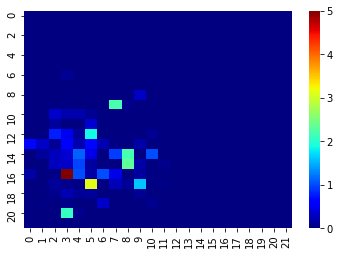

In [18]:
sns.heatmap(dfi.avg_imp.values.reshape(*mp.fmap_shape), vmin=0, vmax=5, cmap = 'jet')

In [19]:
dfi.avg_imp.sort_values(ascending=False).head(20)

355    20.006894
379     3.116000
338     2.314334
205     2.201051
316     2.171483
443     2.088249
269     1.867875
383     1.593316
312     1.102996
318     1.012086
358     1.007508
356     1.004625
334     0.974401
315     0.935076
266     0.770091
286     0.659842
291     0.658891
289     0.616295
267     0.503196
313     0.465901
Name: avg_imp, dtype: float64